In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import libraries and packages
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
!pip install pmdarima
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# import dataset
# please download the dataset here: https://www.kaggle.com/code/ysthehurricane/advanced-stock-pred-using-svr-rfr-knn-lstm-gru/data
# df = pd.read_csv("/content/drive/MyDrive/CIS 5190 Team Project/RELIANCE.csv")

# MODIFY PATH HERE
path_name = "/content/drive/MyDrive/Reliance.csv"
df = pd.read_csv(path_name)
# Rename columns
df.rename(columns={"Date":"date","Open":"open","High":"high","Low":"low","Close":"close"}, inplace= True)
df.head()

(5306, 15)


,date,Symbol,Series,Prev Close,open,high,low,Last,close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


### Checking null values
We impute null values with the mean if they exists. Since only the irrelevant columns have nulls, we can drop and ignore them

In [ ]:
df.isnull().sum()

date                     0
Symbol                   0
Series                   0
Prev Close               0
open                     0
high                     0
low                      0
Last                     0
close                    0
VWAP                     0
Volume                   0
Turnover                 0
Trades                2850
Deliverable Volume     514
%Deliverble            514
dtype: int64

## Create dataset
We will use the close_price as our prediction variable and just use the previous close values to predict future close values in this time series analysis

In [ ]:
# convert date to Date format
df['date'] = pd.to_datetime(df.date)
df['month'] = df.date.dt.month
df['week'] = df.date.dt.week
df['day'] = df.date.dt.day
# it's important we sort by date so that all entries are in order for time series
df.sort_values(by = 'date', inplace=True)

<ipython-input-10-5cc9cb829870>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df.date.dt.week


In [ ]:
df

,date,Symbol,Series,Prev Close,open,high,low,Last,close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,month,week,day
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN,1,1,3
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN,1,1,4
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN,1,1,5
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN,1,1,6
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN,1,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5301,2021-04-26,RELIANCE,EQ,1904.35,1920.00,1962.00,1911.50,1938.00,1937.85,1941.32,9620785,1.867699e+15,259137.0,4276703.0,0.4445,4,17,26
5302,2021-04-27,RELIANCE,EQ,1937.85,1940.00,1997.20,1938.25,1990.00,1988.65,1978.64,9226547,1.825602e+15,291197.0,3772144.0,0.4088,4,17,27
5303,2021-04-28,RELIANCE,EQ,1988.65,1997.85,2008.00,1980.15,1993.15,1997.30,1997.60,7902002,1.578508e+15,247331.0,3921560.0,0.4963,4,17,28
5304,2021-04-29,RELIANCE,EQ,1997.30,2022.90,2044.50,2007.30,2020.00,2024.05,2024.21,8035915,1.626634e+15,213153.0,2834103.0,0.3527,4,17,29


In [ ]:
# create dataframe to use
data = df[['date', 'month', 'day', 'week', 'close', 'high', 'low', 'Volume', 'VWAP']]

In [ ]:
data

,date,month,day,week,close,high,low,Volume,VWAP
0,2000-01-03,1,3,1,251.70,251.70,237.50,4456424,249.37
1,2000-01-04,1,4,1,271.85,271.85,251.30,9487878,263.52
2,2000-01-05,1,5,1,282.50,287.90,256.65,26833684,274.79
3,2000-01-06,1,6,1,294.35,300.70,289.00,15682286,295.45
4,2000-01-07,1,7,1,314.55,317.90,293.00,19870977,308.91
...,...,...,...,...,...,...,...,...,...
5301,2021-04-26,4,26,17,1937.85,1962.00,1911.50,9620785,1941.32
5302,2021-04-27,4,27,17,1988.65,1997.20,1938.25,9226547,1978.64
5303,2021-04-28,4,28,17,1997.30,2008.00,1980.15,7902002,1997.60
5304,2021-04-29,4,29,17,2024.05,2044.50,2007.30,8035915,2024.21


In [ ]:
data.shape

(5306, 9)

## Feature Engineering

This function creates rolling averages and standard deviations over the span of 3, 7, and 30 days (representing days, weeks and months). We create these features to give us a better understanding of the past data in the prediction step

In [ ]:
lag_data = data.copy()
# we leverage the remaining features from the dataset and create rolling statistics of them as features
features = ["high", "low", "Volume", "VWAP"]


# account for the windows
w1 = 3
w2 = 7
w3 = 30

windows = [w1, w2, w3]

def moving_average(data, w):
  rolled_data = data[features].rolling(window=w, min_periods = 0)
  mean_data = rolled_data.mean().shift(1).reset_index().astype(np.float32)
  std_data = rolled_data.std().shift(1).reset_index().astype(np.float32)
  # append the moving average into the dataset
  for f in features:
    data[f"{f}_average_lag_{w}"] = mean_data[f]
    data[f"{f}_std_lag_{w}"] = std_data[f]

for w in windows:
  moving_average(lag_data, w)


In [ ]:
lag_data = lag_data.fillna(lag_data.mean())
lag_data.set_index("date", drop=False, inplace=True)

<ipython-input-15-bdfd975b039d>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  lag_data = lag_data.fillna(lag_data.mean())


In [ ]:
lag_data

,date,month,day,week,close,high,low,Volume,VWAP,high_average_lag_3,...,VWAP_average_lag_7,VWAP_std_lag_7,high_average_lag_30,high_std_lag_30,low_average_lag_30,low_std_lag_30,Volume_average_lag_30,Volume_std_lag_30,VWAP_average_lag_30,VWAP_std_lag_30
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,1,3,1,251.70,251.70,237.50,4456424,249.37,1026.298584,...,1010.776978,21.450975,1022.001343,47.826427,992.129028,47.708832,5595386.0,2583829.50,1007.152771,47.009243
2000-01-04,2000-01-04,1,4,1,271.85,271.85,251.30,9487878,263.52,251.699997,...,249.369995,21.450975,251.699997,47.826427,237.500000,47.708832,4456424.0,2583829.50,249.369995,47.009243
2000-01-05,2000-01-05,1,5,1,282.50,287.90,256.65,26833684,274.79,261.774994,...,256.445007,10.005561,261.774994,14.248201,244.399994,9.758074,6972151.0,3557775.25,256.445007,10.005561
2000-01-06,2000-01-06,1,6,1,294.35,300.70,289.00,15682286,295.45,270.483337,...,262.559998,12.737163,270.483337,18.138657,248.483337,9.880832,13592662.0,11739778.00,262.559998,12.737163
2000-01-07,2000-01-07,1,7,1,314.55,317.90,293.00,19870977,308.91,286.816681,...,270.782501,19.457516,278.037506,21.156614,258.612488,21.805672,14115068.0,9642262.00,270.782501,19.457516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,2021-04-26,4,26,17,1937.85,1962.00,1911.50,9620785,1941.32,1917.449951,...,1916.474243,16.059166,2049.084961,93.538704,1999.770020,83.226593,8290544.0,2535853.00,2022.781372,87.668701
2021-04-27,2021-04-27,4,27,17,1988.65,1997.20,1938.25,9226547,1978.64,1931.783325,...,1917.892822,17.926355,2040.088379,88.174873,1991.219971,78.382462,8311156.5,2544338.00,2013.969971,81.737671
2021-04-28,2021-04-28,4,28,17,1997.30,2008.00,1980.15,7902002,1997.60,1959.366699,...,1924.365723,29.116863,2032.868286,82.120445,1984.275024,73.199394,8385582.0,2537119.75,2007.208984,75.560204


We need to do an adafuller test to check for stationarity within the data. Even if we find non-stationarity, we will use auto-arima to account for it

In [ ]:
# H0: Data is non stationary
# H1: Data is stationary

def adfuller_test(x):
  result = adfuller(x)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
  if result[1]>0.05:
    print("Fail to reject the null hypothesis (H0), the data is non-stationary")
  else:
    print("Reject the null hypothesis (H0), the data is stationary.")
  

In [ ]:
adfuller_test(lag_data['close'])

ADF Statistic: -1.849052
p-value: 0.356395
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Fail to reject the null hypothesis (H0), the data is non-stationary


Since this is non-stationary, we need to convert the data into stationary

In [ ]:
lag_data['close_diff'] = lag_data['close'] - lag_data['close'].shift(1)

## ARIMA Model

In [ ]:
lag_data

,date,month,day,week,close,high,low,Volume,VWAP,high_average_lag_3,...,VWAP_std_lag_7,high_average_lag_30,high_std_lag_30,low_average_lag_30,low_std_lag_30,Volume_average_lag_30,Volume_std_lag_30,VWAP_average_lag_30,VWAP_std_lag_30,close_diff
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,1,3,1,251.70,251.70,237.50,4456424,249.37,1026.298584,...,21.450975,1022.001343,47.826427,992.129028,47.708832,5595386.0,2583829.50,1007.152771,47.009243,NaN
2000-01-04,2000-01-04,1,4,1,271.85,271.85,251.30,9487878,263.52,251.699997,...,21.450975,251.699997,47.826427,237.500000,47.708832,4456424.0,2583829.50,249.369995,47.009243,20.15
2000-01-05,2000-01-05,1,5,1,282.50,287.90,256.65,26833684,274.79,261.774994,...,10.005561,261.774994,14.248201,244.399994,9.758074,6972151.0,3557775.25,256.445007,10.005561,10.65
2000-01-06,2000-01-06,1,6,1,294.35,300.70,289.00,15682286,295.45,270.483337,...,12.737163,270.483337,18.138657,248.483337,9.880832,13592662.0,11739778.00,262.559998,12.737163,11.85
2000-01-07,2000-01-07,1,7,1,314.55,317.90,293.00,19870977,308.91,286.816681,...,19.457516,278.037506,21.156614,258.612488,21.805672,14115068.0,9642262.00,270.782501,19.457516,20.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,2021-04-26,4,26,17,1937.85,1962.00,1911.50,9620785,1941.32,1917.449951,...,16.059166,2049.084961,93.538704,1999.770020,83.226593,8290544.0,2535853.00,2022.781372,87.668701,33.50
2021-04-27,2021-04-27,4,27,17,1988.65,1997.20,1938.25,9226547,1978.64,1931.783325,...,17.926355,2040.088379,88.174873,1991.219971,78.382462,8311156.5,2544338.00,2013.969971,81.737671,50.80
2021-04-28,2021-04-28,4,28,17,1997.30,2008.00,1980.15,7902002,1997.60,1959.366699,...,29.116863,2032.868286,82.120445,1984.275024,73.199394,8385582.0,2537119.75,2007.208984,75.560204,8.65


In [ ]:
df_train = lag_data[lag_data.date < "2019"]
df_test = lag_data[lag_data.date >= "2019"]

exogenous_features = ["high_average_lag_3", "high_average_lag_7", "high_average_lag_30",
                      "low_average_lag_3", "low_average_lag_7", "low_average_lag_30",
                      "VWAP_average_lag_3", "VWAP_average_lag_7", "VWAP_average_lag_30",
                      "high_std_lag_3", "high_std_lag_7", "high_std_lag_30",
                      "low_std_lag_3", "low_std_lag_7", "low_std_lag_30",
                      "VWAP_std_lag_3", "VWAP_std_lag_7", "VWAP_std_lag_30",
                      "month","week","day"]

In [ ]:
# first we find the most optimal model
model = auto_arima(df_train.close, exogenous=df_train[exogenous_features], trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=46534.334, Time=11.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46575.276, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46571.295, Time=0.92 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=46571.287, Time=1.64 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46573.420, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=46562.819, Time=5.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=46560.346, Time=5.90 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=46535.054, Time=8.82 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=46535.045, Time=8.56 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=46573.282, Time=1.98 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=46546.351, Time=2.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=46543.550, Time=6.08 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=46535.601, Time=7.49 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=46532.503, Time=1.64 sec
 ARIMA(1,1,2)(0,0,

In [ ]:
# next we create the most optimal model. we choose p = 3, d = 0 and q = 0 since we want a lag of 3 but do not want to factor in differencing and moving averages
# since those are accounted for in our exogenous variables already
model = ARIMA(df_train.close, exog=df_train[exogenous_features], order=(3, 0, 0), trend="t")
results = model.fit()
# forecast the results past 2019
forecast = results.forecast(len(df_test), exog=df_test[exogenous_features])

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-pa

In [ ]:
df_test

,date,month,day,week,close,high,low,Volume,VWAP,high_average_lag_3,...,VWAP_std_lag_7,high_average_lag_30,high_std_lag_30,low_average_lag_30,low_std_lag_30,Volume_average_lag_30,Volume_std_lag_30,VWAP_average_lag_30,VWAP_std_lag_30,close_diff
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,2019-01-01,1,1,1,1121.00,1127.30,1110.10,4455850,1119.01,1132.033325,...,17.844547,1137.078369,22.040287,1111.898315,25.280838,7821679.5,2533373.00,1124.663330,23.560802,-0.25
2019-01-02,2019-01-02,1,2,1,1106.40,1127.00,1101.00,7144970,1113.42,1132.133301,...,17.226351,1136.989990,22.075125,1112.331665,25.129398,7602478.5,2530525.75,1124.574951,23.577414,-14.60
2019-01-03,2019-01-03,1,3,1,1092.75,1114.60,1090.10,7446457,1101.37,1129.383301,...,17.239620,1136.166626,21.967924,1111.331665,24.957212,7597011.5,2531358.75,1123.593628,23.402138,-13.65
2019-01-04,2019-01-04,1,4,1,1098.65,1104.45,1081.10,8465141,1093.06,1122.966675,...,16.199594,1134.790039,21.982721,1110.001709,24.991186,7654563.0,2506717.25,1122.199951,23.440414,5.90
2019-01-07,2019-01-07,1,7,2,1104.75,1118.45,1101.00,5513559,1110.32,1115.349976,...,12.739732,1133.421631,22.563017,1109.136719,25.539942,7686474.0,2510874.75,1121.408325,24.022564,6.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,2021-04-26,4,26,17,1937.85,1962.00,1911.50,9620785,1941.32,1917.449951,...,16.059166,2049.084961,93.538704,1999.770020,83.226593,8290544.0,2535853.00,2022.781372,87.668701,33.50
2021-04-27,2021-04-27,4,27,17,1988.65,1997.20,1938.25,9226547,1978.64,1931.783325,...,17.926355,2040.088379,88.174873,1991.219971,78.382462,8311156.5,2544338.00,2013.969971,81.737671,50.80
2021-04-28,2021-04-28,4,28,17,1997.30,2008.00,1980.15,7902002,1997.60,1959.366699,...,29.116863,2032.868286,82.120445,1984.275024,73.199394,8385582.0,2537119.75,2007.208984,75.560204,8.65


We plot to compare ARIMA's performance to the actual

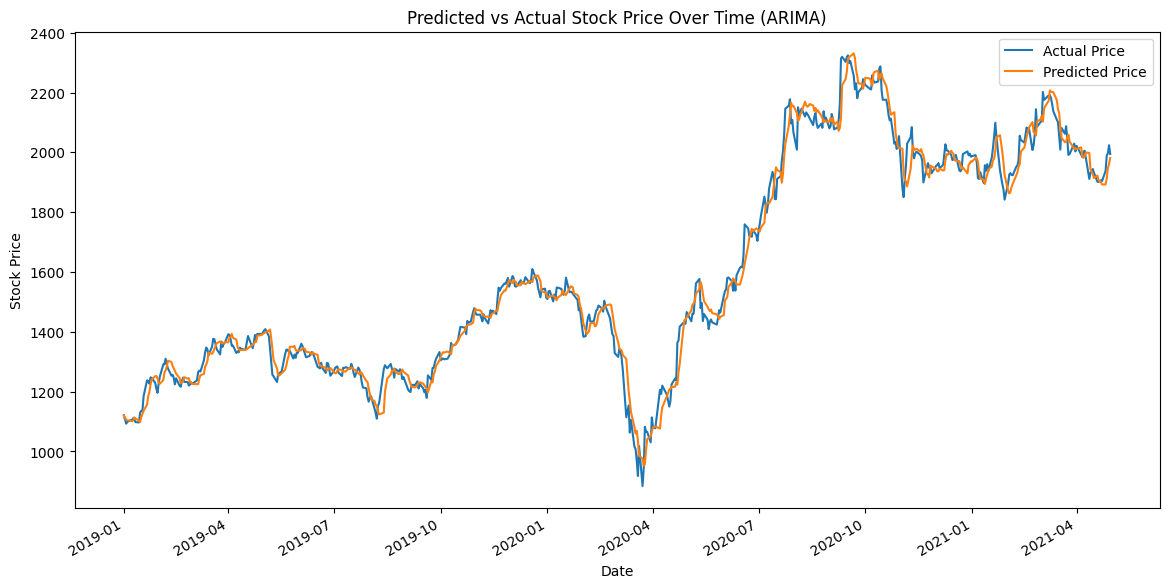

In [ ]:
result = df_test.drop(columns=['date']).reset_index()
result['forecast'] = list(forecast)
result.set_index("date", inplace=True)
result[["close", "forecast"]].plot(figsize=(14, 7))
plt.xlabel('Date')
plt.ylabel("Stock Price")
plt.title("Predicted vs Actual Stock Price Over Time (ARIMA)")
plt.legend(labels = ["Actual Price","Predicted Price"])

Finally we compute the metrics of ARIMA

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(result.close, result.forecast)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(result.close, result.forecast))

r2 = r2_score(result.close, result.forecast)
print(f"The r2 value is {r2}")

RMSE of Auto ARIMAX: 43.29813875640212

MAE of Auto ARIMAX: 31.892392244426073
The r2 value is 0.9856291251885324


We need to scale the data in order to ensure that we account for non scale-invariant models

## Creating Train and Test sets
Since this is time series data, we have to split the data such that we can maintain the ordering of the dates. Thus, we manually select the first 80% of the data to be our training set and then choose the remaining portions of the data to be our test set

In [ ]:
# at this point we only care about the close_value, since we will be using the close values to predict future values
features = exogenous_features
X_train = df_train[features]
y_train = df_train['close']
X_test = df_test[features]
y_test = df_test['close']

## Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
regressor = RandomForestRegressor(n_estimators=100, random_state = 42)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
prediction = regressor.predict(X_test)

In [ ]:
graph = pd.DataFrame(y_test)
graph = graph.reset_index()
graph['prediction'] = list(prediction)
graph.set_index('date', inplace=True)

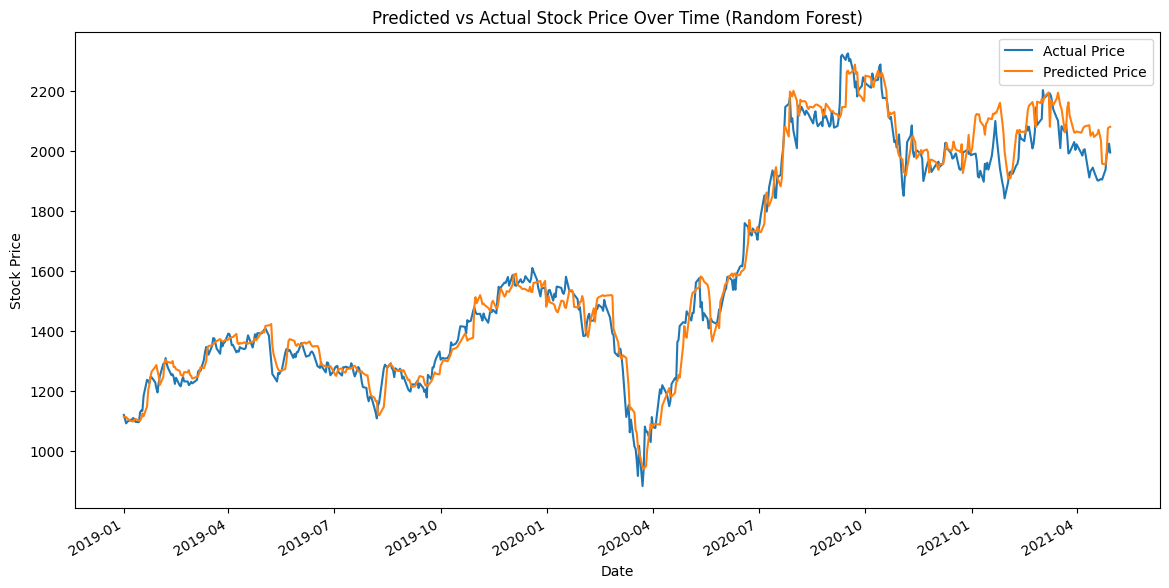

In [ ]:
graph.plot(figsize=(14, 7))
plt.xlabel('Date')
plt.ylabel("Stock Price")
plt.title("Predicted vs Actual Stock Price Over Time (Random Forest)")
plt.legend(labels = ["Actual Price","Predicted Price"])

In [ ]:
mse = np.sqrt(mean_squared_error(y_test, prediction))
mae = mean_absolute_error(y_test, prediction)
r2 = r2_score(y_test, prediction)
print(f"The MSE is {mse}")
print(f"The r2 value is {r2}")
print(f"The MAE is {mae}")

The MSE is 60.4839383190151
The r2 value is 0.9719569740367486
The MAE is 44.20583102253036


## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [ ]:
predictions = reg.predict(X_test)

In [ ]:
graph = pd.DataFrame(y_test)
graph = graph.reset_index()
graph['prediction'] = list(predictions)
graph.set_index('date', inplace=True)

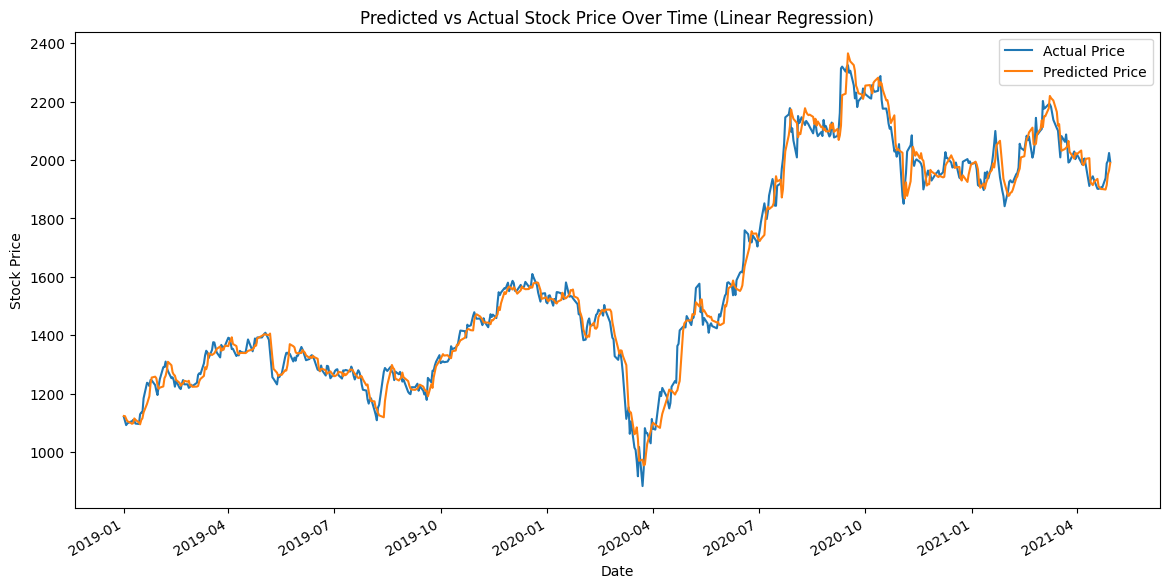

In [ ]:
graph.plot(figsize=(14, 7))
plt.xlabel('Date')
plt.ylabel("Stock Price")
plt.title("Predicted vs Actual Stock Price Over Time (Linear Regression)")
plt.legend(labels = ["Actual Price","Predicted Price"])

In [ ]:
from sklearn.metrics import r2_score
mse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"The MSE is {mse}")
print(f"The r2 value is {r2}")
print(f"The MAE is {mae}")

The MSE is 43.99181513058335
The r2 value is 0.985164967105696
The MAE is 32.28379709497914
